# Basic calculation showing effect of subsidence including loading from unconfined aquifer

Subsidence in aquifers is the result of compaction of clay layers in response to lowering of effective stress within those layers. The effective stress change in a layer is equal to the change in overburden stress minus the change in pore fluid pressure within that layer. It is common to assume overburden stress remains constant when making these calculations. This notebook investigates whether that assumption is sensible.

## Equations

### Compaction in confined

In a confined aquifer, the change in effective stress is written:

\begin{equation}
\Delta \sigma_{eff} = \Delta F - \Delta P
\end{equation}
where $\sigma_{eff}$ is the effective stress, $ F $ is the overburden stress and $ P $ is the pore fluid pressure. 

We can make a few substitutions to get this expression in terms of head changes:
\begin{equation}
\Delta b = b_0 \big(\alpha \Delta F - S_{sk} \Delta h \big)
\end{equation}
where $b_0$ is the original thickness of the layer, $\alpha$ is the compressibility of the layer, $S_{sk}$ is the specific storage of the layer and $h$ is the head in the layer.

### Compaction in unconfined

In an unconfined aquifer, this is modified slightly because a change in head changes both the pressure and the weight of water in the layer by differing amounts. Hence, in an unconfined aquifer, the equation becomes:

\begin{equation}
\Delta \sigma_{eff} = \Delta F - (1-S_y) \Delta P
\end{equation}
where $S_y$ is the specific yield and $F$ is now overburden stress not including that due to changing mass of the unconfined aquifer.

In terms of heads, we get:
\begin{equation}
\Delta b = b_0 \big(\alpha \Delta F - (1-S_y) \rho_w g \alpha \Delta h \big)
\end{equation}

### Thickness of clay deforming

In both cases we assume the layer which is deforming is a clay layer. The thickness of clay which deforms depends on the thickness over which head changes. This is a time-dependent process since clay layers have a low hydraulic conductivity. The time taken for head in a clay layer to equilibrate with changes at its boundaries can be estimated using:
\begin{equation}
\tau \approx \Big(\frac{b_0}{2} \Big)^2 S_k /K_v
\end{equation}
where $S_k$ is the specific storage and $K_v$ is the vertical hydraulic conductivity of the layer. 

We can use this relationship to determine what thickness of clay layers are affected by changes in head.

## Model Setup

I will take a simple model with three layers: an uppermost unconfined aquifer, a confining layer (Corcoran Clay), and a lowermost confined aquifer. For the two aquifers, I will take a time series of head changes from 2000 to present. The time series will consist of two datapoints per year. I will use the equation above to estimate how much the Corcoran Clay experiences these head changes, as well as what thickness of interbedded clays. I will need some model of the interbedded clays. I will then solve the equations for compaction, initially assuming $\Delta F$ is constant in all cases and then including the changing head in the unconfined layer in the $\Delta F$ for the confined aquifer.

### How thick should clays be?

I am modelling that head changes occur on a time period of 6 months. Over 6 months, what thicknesses of clay will equilibrate to those head changes? I need to solve this equation:

\begin{equation}
b_0 = \sqrt{4 \tau  \frac{K_v}{S_k} }
\end{equation}

Taking $\tau = 1.6 \times 10^{6} s$, $K_v = 10^{-10} m/s$, and $S_k \approx 10^{-3} $m, we get $b_0 = 0.8$ m.

### What, therefore, is $b_0$?

Here I will copy from Ryan's thesis. He quotes on page 39 that the total clay thickness in the study area is between 197 and 514 m. This seems rather large to me! So I will take the lower number of 200 m as my truth. I will then use his histogram to estimate how many are as thin as 1 m such that they will equilibrate with head changes over 6 months. Histogram:

<img src="Ryan_Histogram.png" >

So I interpret that only a few percent of the clay layers are as thin as 1 m. Of course, ones thicker than 1 m will also equilibrate but only partially. So, I shall take 5% as a ballpark number, and say that $b_0$  is 5% of 200m; that is, 10 m. 

### But how are these clay layers distributed between the confined and unconfined  aquifers?

I don't know the answer to this. For now I am going to assume 7 m of clay in the confined and 3 m in the unconfined.

### Where do the time series come from?

I will use this sort of method:

<img src="Wells_V1.png" >

where I shall take a mean series of unconfined as upper dashed, and a mean series of confined as the lower solid and lower dotted.

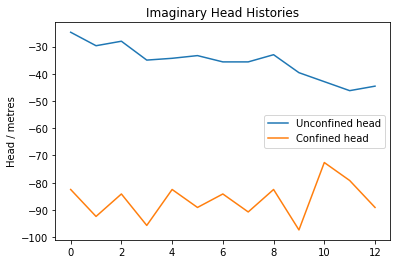

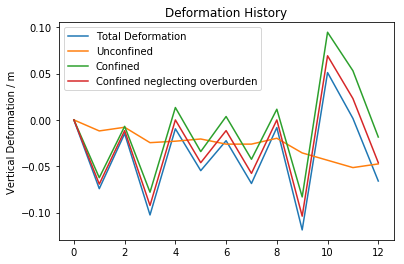

In [2]:
# Imaginary  version

import matplotlib.pyplot as plt
import numpy as np

head_unc = -0.33 * np.array([75,90,85,106,104,101,108,108,100,120,130,140,135])

head_con = -0.33 * np.array([250,280,255,290,250,270,255,275,250,295,220,240,270])

plt.plot(head_unc,label='Unconfined head')
plt.plot(head_con,label='Confined head')
plt.legend()
plt.title('Imaginary Head Histories')
plt.ylabel('Head / metres')
plt.show()

# Now work out the answer, omg

S_y = 0.2
rho = 1000
g = 10

b0_con = 7
b0_unc = 3
alpha =  10**(-7)
Ssk = rho * g * alpha
Sy = 0.2

delta_head_unc =  np.diff(head_unc)
delta_F_unc = np.zeros_like(delta_head_unc)

delta_head_con = np.diff(head_con)
delta_F_con = S_y * rho *  g * delta_head_unc
delta_b_con = -b0_con * (alpha*delta_F_con -  Ssk * delta_head_con)
b_con = np.cumsum(delta_b_con)
b_con = np.insert(b_con,0,0)

b_con_Classic = np.cumsum(-b0_con * ( - Ssk*delta_head_con))
b_con_Classic = np.insert(b_con_Classic,0,0)

delta_b_unc = -b0_unc*(alpha*delta_F_unc - (1-Sy) * rho* g *  alpha * delta_head_unc)
b_unc = np.cumsum(delta_b_unc)
b_unc = np.insert(b_unc,0,0)

b_tot = b_con + b_unc

plt.plot(b_tot,label="Total Deformation")
plt.plot(b_unc,label="Unconfined")
plt.plot(b_con,label="Confined")
plt.plot(b_con_Classic,label="Confined neglecting overburden")
plt.legend()
plt.title("Deformation History")
plt.ylabel('Vertical Deformation / m')
plt.show()

In [3]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')
